In [1]:
# Authors: Stylianos Kampakis & Shreesha Jagadeesh

### Purpose

This notebook is meant to give a general overview for creating a binary classifier on an imbalanced datasets using familiar sklearn-based ML algorithms. 
The dataset is given here https://www.kaggle.com/mlg-ulb/creditcardfraud

Also the notebook contains useful boilerplate code that can be used to explore the kind of datasets used in this LiveProjects
    

<a id="top"></a> <br>
## Table of  Contents
1. [Introduction](#1)

1. [Initialization](#2)
    1. [Load packages](#21)
    1. [Define Metadata](#22)
    
1. [Load Data](#3)

1. [Data Insights](#4)
    1. [Data Structure](#41)
    1. [Summary Stats](#42)
    1. [Unique Value Checking](#43)
    1. [Identifying 'Bad Columns'](#44)

1. [Data Cleansing](#5)
    1. [Data Reduction](#51)
        1. [Dropping Bad Columns](#511)
        1. [Null Value Removal](#512)

1. [Modelling Workflow](#6)
    1. [Data Prep](#61)
        1. [Feature Target Split](#611)
        1. [Train-Test Split](#612)
        1. [Normalizing Numerical Variables](#613)
    1. [Estimate of Baseline Accuracy - Class Distributions](#62)
    1. [Predictive Modelling](#63)
        1. [Modelling with Random Forest](#631)
        1. [Model Comparison without Resampling](#632)
        1. [(Advanced) Resampling methods](#633)
  

# <a id='1'>Introduction</a>  

Assume you work for a financial institution that issues credit cards to customers. Once the credit card is in the hands of the customers, it is important that the customer is alerted and the card possibly blocked upon the detection of fraudulent transactions. In this dataset, we deal with anonymized data from a Kaggle competition

"The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise."


## <a id='2'>Initialization</a>  


### <a id='21'>Load Packages</a>  

Load the minimum number of packages to get started and add more as we go along

In [2]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import scipy
from scipy.io.arff import loadarff

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict

import warnings
warnings.filterwarnings('ignore')
# This is to suppress any deprecation warnings 

import os
import sys

### <a id='22'>Define Metadata</a>  

In [3]:
# Define the name of the target class column here instead of manually typing it out everywhere
target_class_name = 'Class'

# Fill in the names of what you want to call the 0 and 1 class
labels = ['Not Fraud', 'Fraud']

input_file_name = 'creditcard.csv'
raw_data_folder = '../data/raw/'

# cleaned_dataframe_name = 'week1_cleaned_df_output_' 

# Enter the date in which this notebook is run
export_date = '20211016'


## <a id='3'>Load Data</a>  

In [4]:
# Read the data from the raw sub-folder within the data folder
df = pd.read_csv(raw_data_folder + input_file_name)

# Take a random sample to see how the data looks like
df.sample(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
198759,132639.0,1.976920,-0.223912,-1.110343,0.385536,-0.179055,-0.936379,0.093771,-0.167433,0.420519,...,-0.188822,-0.480127,0.275423,0.074037,-0.266810,0.251367,-0.084892,-0.070845,20.99,0
45260,42270.0,-1.093759,1.403060,0.708704,-0.202083,-0.188901,-0.567077,0.321728,0.421297,0.004099,...,-0.327118,-0.816815,-0.008386,-0.104824,-0.106667,0.064139,0.156878,-0.082312,12.65,0
212241,138777.0,-0.714122,0.385490,1.196443,-1.085687,0.421323,-0.894228,0.216707,0.230857,0.377887,...,-0.122113,-0.498204,0.004635,-0.097931,-0.544803,-0.416124,0.121574,0.176655,0.69,0
23367,32723.0,1.330251,0.226680,-1.710429,-0.069318,2.555174,3.063217,-0.031618,0.646999,-0.400803,...,-0.050385,-0.244080,-0.181290,1.010082,1.009321,-0.280674,-0.006202,0.004151,2.69,0
65358,51544.0,-0.283661,0.717007,-0.029250,-0.359441,2.652987,3.725111,0.206798,0.932261,-0.418040,...,-0.108348,-0.291255,-0.293121,1.004151,0.425776,-0.367583,0.079486,0.051896,1.00,0


Lets check the head & tail to make sure there is nothing going on

In [5]:
df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [6]:
df.tail(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


No trouble with loading the data. Both the head and tail are clean

## <a id=4 > Data Insights

### <a id='41'>Data Structure</a> 

In [7]:
# Lets see the data structure
df.info()
# This will give you how many rows & columns are there

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

None of the columns have null values

### <a id='42'>Summary Stats</a> 

In [8]:
df.describe()
# check out each column's summary statistics
# Note that only the numerical columns will be described
# Also you will want to exclude the discrete columns whose summary stats will give non-sensical values like 'customer_id' 

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


### <a id='43'>Unique Value Checking</a> 

In [9]:
for column in df.columns:
    print(column, len(df[column].unique()))

Time 124592
V1 275663
V2 275663
V3 275663
V4 275663
V5 275663
V6 275663
V7 275663
V8 275663
V9 275663
V10 275663
V11 275663
V12 275663
V13 275663
V14 275663
V15 275663
V16 275663
V17 275663
V18 275663
V19 275663
V20 275663
V21 275663
V22 275663
V23 275663
V24 275663
V25 275663
V26 275663
V27 275663
V28 275663
Amount 32767
Class 2


### <a id='44'>Identifying Bad Columns</a> 

In [10]:
def find_bad_columns_function(dataframe):
    '''
    Args: dataframe for which there maybe bad columns
    
    Logic: Find the columns that have quasi constant/constant values defined by less than 1% variance
    
    Returns: 5 lists containing those features that have nulls, blanks, constant values throughout and 
    those features that are duplicate of other features
    
    '''
    
    ###### Finding Null Values
    null_col_list = dataframe.columns[dataframe.isna().any()].tolist()
    
    print('Identified {} features with atleast one null'.format(
        len(null_col_list)))

    ###### Finding Blank Spaces in the object column
    # Non-obvious nulls such as blanks: The line items where there are spaces 
    blank_space_col_list = []
    object_columns = dataframe.select_dtypes(include=['object']).columns

    for col in object_columns:
        if sum(dataframe[col]==' '):
            blank_space_col_list.append(col)

    print('Identified {} features with atleast one blank space'.format(
        len(blank_space_col_list)))
    
    ####### Finding Quasi Constant/Constant Value in numerical columns
    # Lets remove the variables that have more than 99% of their values as the same 
    # ie their standard deviation is less than 1 %
    
    numeric_df = dataframe._get_numeric_data()
    constant_numeric_col_list = [col for col in numeric_df.columns if numeric_df[col].std()<0.01]

    print('Identified {} numeric features that have quasi-constant values'.format(
        len(constant_numeric_col_list)))
    
    # We didnt use the following code snippet for the above because if you have closely varying float values
    # then the below wont pick it up
    
    ###### Finding Quasi Constant/Constant non_numeric value
    constant_non_numeric_col_list = []
    
    # Find the columns that are not in numeric_df
    non_numeric_col_set = set(dataframe.columns) - set(numeric_df.columns)   

    for col in non_numeric_col_set:
        categorical_mode_value = (dataframe[col].mode().values)[0]
        fractional_presence = sum(dataframe[col]==categorical_mode_value)/len(dataframe) 
    
        if fractional_presence > 0.99:
            constant_non_numeric_col_list.append(col)
            
    print('Identified {} non-numeric features that have quasi-constant values'.format(
        len(constant_non_numeric_col_list)))
    
    return null_col_list, blank_space_col_list, constant_numeric_col_list, constant_non_numeric_col_list

In [11]:
# use the above custom function to figure out the if there are any columns we need to be concerned about
null_col_list, blank_space_col_list, constant_numeric_col_list, \
constant_non_numeric_col_list = find_bad_columns_function(df)

Identified 0 features with atleast one null
Identified 0 features with atleast one blank space
Identified 0 numeric features that have quasi-constant values
Identified 0 non-numeric features that have quasi-constant values


There doesn't seem to be any obvious columns that need attention

## <a id='5'>Data Cleansing</a> 

#### <a id='51'>Data Reductions</a> 

#### <a id='511'>Dropping Bad Columns</a> 

In [12]:
# In this dataset, we dont have anything of concern that need deletion but 
# But if they do show up, you should go ahead and delete them to reduce overfitting

print('Before dropping irrelevant features and duplicated columns,')
print('{} number of columns were present'.format(len(df.columns)))

for drop_column_list in [constant_numeric_col_list, constant_non_numeric_col_list]:
    df.drop(drop_column_list, axis=1, inplace=True)

print('After dropping the above, ')
print('{} number of columns are present'.format(len(df.columns)))


Before dropping irrelevant features and duplicated columns,
31 number of columns were present
After dropping the above, 
31 number of columns are present


#### <a id='512'>Null Value Removal</a> 

In [13]:
df.dropna(axis=0, inplace=True)
len(df)

284807

## <a id = 6 > Modelling Workflow

### <a id = 61 > Data Prep 

#### <a id='611'>Feature - Target Split</a> 

In [14]:
X = df.drop(target_class_name, axis=1)
y = df[target_class_name]

#### <a id='612'>Train Test Split</a> 

In [15]:
# split into train and test set 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Note optionally convert the pandas dataframe into a numpy array using to_numpy if you have a big data
# and want to model faster. Otherwise it doesnt matter which data structure you use

#### <a id = 612 > Normalizing numerical variables

Now that we have numerical features, can we feed it directly into our models like Random Forest? Yes even without scaling or normalizing. Scaling has the effect of squeezing all data range into a tight range but is not required for non-distance based models

https://stats.stackexchange.com/questions/244507/what-algorithms-need-feature-scaling-beside-from-svm

### <a id='62'>Estimate of baseline accuracy - Class Distributions </a> 

In [16]:
# Figure out the class distribution percentage and round it to 3 decimal places

print('Percentage of Negative class is {} %'.format(
    round(df[target_class_name].value_counts()[0]/len(df) * 100,3)))

print('Percentage of Positive class is {} %'.format(
    round(df[target_class_name].value_counts()[1]/len(df) * 100,3)))

# A dumb model that predicts everything as being 0, will generate a baseline accuracy of 99.8%

Percentage of Negative class is 99.827 %
Percentage of Positive class is 0.173 %


0    284315
1       492
Name: Class, dtype: int64

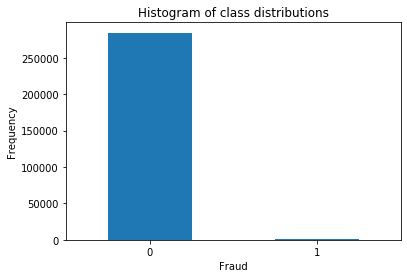

In [17]:
plt.figure(figsize=(6,4))
pd.value_counts(df[target_class_name]).plot.bar()
plt.title('Histogram of class distributions')
plt.xlabel(labels[1])
plt.xticks(rotation=0)
plt.ylabel('Frequency')
df[target_class_name].value_counts()

The baseline accuracy to beat is 99.8%

What about the other metrics like Precision, Recall and F1 score? They would all be 0% for the positive class for a non-predictive 'classifier' that predicts every  

### <a id='63'>Predictive Modelling</a> 

#### <a id='631'>Modelling with Random Forest</a> 

In [18]:
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, average_precision_score
from collections import Counter

In [19]:
def custom_classification_metrics_function(X_test, y_test, labels, classifier):
    '''
    Args: The features and the target column; the labels are the categories, sklearn classifier object
    Calculates Classification metrics of interest
    Returns: A dictionary containing the classification metrics
    '''

    # Generate the predictions on the test data which forms the basis of the evaluation metrics
    test_pred = classifier.predict(X_test)

    ### Classification report
    print(classification_report(y_test, test_pred, target_names=labels))
    
    ### ROC AUC curve

    # Only store the 2nd column which corresponds to the probability for the positive class
    y_scores = classifier.predict_proba(X_test)[:, 1]

    ### Confusion Matrix
    confusion_matrix_test_object = confusion_matrix(y_test, test_pred)
                
    # Initialize a dictionary to store the metrics we are interested in
    metrics_dict = Counter()

    # These are all the basic threshold-dependent metrics
    metrics_dict['Accuracy']  = float("{0:.3f}".format(accuracy_score(y_test, test_pred)))

    # The following are more useful than the accuracy
    metrics_dict['Precision'] = float("{0:.2f}".format(precision_score(y_test, test_pred, average='macro')))
    metrics_dict['Recall'] = float("{0:.2f}".format(recall_score(y_test, test_pred, average='macro')))
    metrics_dict['F1'] = float("{0:.2f}".format(f1_score(y_test, test_pred, average='macro')))

    metrics_dict['TN'] = confusion_matrix_test_object[0][0]
    metrics_dict['TP'] = confusion_matrix_test_object[1][1]
    metrics_dict['FN'] = confusion_matrix_test_object[1][0]
    metrics_dict['FP'] = confusion_matrix_test_object[0][1]

    # These two are threshold-invariant metrics
    metrics_dict['ROC AUC'] = float("{0:.2f}".format(roc_auc_score(y_test, y_scores)))
    metrics_dict['Average_Precision'] = float("{0:.2f}".format(
                                        average_precision_score(y_test, test_pred, average='macro', sample_weight=None)))

    return metrics_dict

In [20]:
from sklearn.ensemble import RandomForestClassifier

# Initialize a classifier object with default params
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train, y_train)

custom_classification_metrics_function(X_test, y_test, labels, classifier)

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     56864
       Fraud       0.94      0.82      0.87        98

    accuracy                           1.00     56962
   macro avg       0.97      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962



Counter({'Accuracy': 1.0,
         'Precision': 0.97,
         'Recall': 0.91,
         'F1': 0.94,
         'TN': 56859,
         'TP': 80,
         'FN': 18,
         'FP': 5,
         'ROC AUC': 0.96,
         'Average_Precision': 0.77})

So which metric would you use to compare? Depends on the business problem. If detecting the minority class is needed, ROC AUC and F1 score may not be the right metrics for imbalanced datasets
https://towardsdatascience.com/selecting-the-right-metric-for-skewed-classification-problems-6e0a4a6167a7

The F1 score is sensitive to imbalance but its unable to differentiate between a good recall or a good precision
due to the symmetrical nature of the formula 
F1 = 2*(Precision * Recall)/(Precision + Recall)

A robust metric that is invariant of the threshold chosen is the Average Precision which accounts for all the different thresholds
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html

#### <a id='632'>Model Comparison without Resampling</a> 

In [21]:
# Lets repeat the same for 2 other classifiers, the logistic_regression and the naive bayes

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

# Initialize a classifier to initialize the classifier object 
classifier_dict = {'logreg':LogisticRegression(random_state=42), 
                   'random_forest':RandomForestClassifier(random_state=42), 
                   'naive_bayes':GaussianNB()}

# Initialize a dataframe with the columns that we want to store being the various metrics of interest
metrics_df = pd.DataFrame(
columns = ['Accuracy','Precision','Recall','F1',
           'ROC AUC','FN','TP','FP','TN','Average_Precision'],
index = [classifier_name for classifier_name in classifier_dict.keys()])

metrics_df
# As seen below, the rows are the names of the classifiers and the columns are the metrics of interest
# These NaNs will be replaced with the values of the metrics when you train the model and predict on the test data next

,Accuracy,Precision,Recall,F1,ROC AUC,FN,TP,FP,TN,Average_Precision
logreg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
random_forest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
naive_bayes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
for classifier_name, classifier in classifier_dict.items(): 
    classifier.fit(X_train, y_train)
    print('***********') 
    print(classifier_name) 
    metrics_dict = custom_classification_metrics_function(X_test, y_test, labels, classifier)
    print(metrics_dict)
    
    # store the metrics as a single row in the dataframe against each classifier name
    metrics_df.loc[classifier_name] = metrics_dict

***********
logreg
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     56864
       Fraud       0.71      0.73      0.72        98

    accuracy                           1.00     56962
   macro avg       0.86      0.87      0.86     56962
weighted avg       1.00      1.00      1.00     56962

Counter({'TN': 56835, 'TP': 72, 'FP': 29, 'FN': 26, 'Accuracy': 0.999, 'ROC AUC': 0.95, 'Recall': 0.87, 'Precision': 0.86, 'F1': 0.86, 'Average_Precision': 0.52})
***********
random_forest
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     56864
       Fraud       0.94      0.82      0.87        98

    accuracy                           1.00     56962
   macro avg       0.97      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962

Counter({'TN': 56859, 'TP': 80, 'FN': 18, 'FP': 5, 'Accuracy': 1.0, 'Precision': 0.97, 'ROC AUC': 0.96, 'F1': 0.94, 'Recall': 0.91, 'Avera

In [23]:
metrics_df

,Accuracy,Precision,Recall,F1,ROC AUC,FN,TP,FP,TN,Average_Precision
logreg,0.999,0.86,0.87,0.86,0.95,26,72,29,56835,0.52
random_forest,1,0.97,0.91,0.94,0.96,18,80,5,56859,0.77
naive_bayes,0.992,0.57,0.83,0.61,0.97,33,65,407,56457,0.09


In [24]:
# As seen the NB solution is by far the worst performer amongst the algorithms

#### <a id='633'>(Advanced) Resampling Techniques</a> 

In [25]:
# We are not going to resample here because this is just the baseline notebook, these will be covered in Projects 1 & 2